In [1]:
#Importing
import re #regular expression
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display

sns.set_theme(style='whitegrid') #seting default theme 

# Loading data

In [2]:
#imdb-sqlite on terminal
#Connect to database
con = sqlite3.connect('imdb.db')

In [3]:
#get tables list from catalog table
tables = pd.read_sql_query('SELECT NAME AS "Table_Name" FROM sqlite_master WHERE type = "table"', con)

In [4]:
tables

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes
5,ratings


In [5]:
# convert to list
tables = tables['Table_Name'].to_list()

In [6]:
for table in tables:
    consult = f'PRAGMA TABLE_INFO({table})'
    result = pd.read_sql_query(consult, con)
    #print(f'Table Scheme: {table}')
    display(result)
    #print('-'*100)

Table Scheme: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


# 1- Most famous movies categories in IMDB

In [7]:
display(pd.read_sql_query('PRAGMA TABLE_INFO(titles)', con))

,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


In [8]:
consult = 'SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'
#Creating the SQL consult to get categories

In [9]:
result = pd.read_sql_query(consult, con).sort_values('COUNT', ascending=False)
#format to a pd dataframe

In [10]:
display(result)

,type,COUNT
4,tvEpisode,6027449
3,short,828461
0,movie,586428
11,video,319884
8,tvSeries,213736
6,tvMovie,132765
5,tvMiniSeries,39532
10,tvSpecial,33945
12,videoGame,28997
9,tvShort,10247


## Visualization

In [11]:
result['percentage'] = (result['COUNT']/result['COUNT'].sum()) * 100
#Calcula percetege from all types

In [12]:
display(result.sort_values('percentage', ascending=False))

,type,COUNT,percentage
4,tvEpisode,6027449,73.313724
3,short,828461,10.076827
0,movie,586428,7.132905
11,video,319884,3.890848
8,tvSeries,213736,2.599737
6,tvMovie,132765,1.614862
5,tvMiniSeries,39532,0.480840
10,tvSpecial,33945,0.412884
12,videoGame,28997,0.352699
9,tvShort,10247,0.124637


In [13]:
#Create 4 categories to the plot
#3 firts and 1 that has all the others

others = {}

#getting all result with percentage lower than 5
others['COUNT'] = result[result['percentage'] < 5]['COUNT'].sum()

#getting the percentage
others['percentage'] = result[result['percentage'] < 5]['percentage'].sum()

#Changing name
others['type'] = 'others'

In [14]:
others

{'COUNT': 779109, 'percentage': 9.476543484376897, 'type': 'others'}

In [15]:
#get all types with more than 5%
result = result[result['percentage'] > 5]

In [16]:
#Append with 'others' dataframe
result = result.append(others, ignore_index=True)

In [17]:
display(result)

,type,COUNT,percentage
0,tvEpisode,6027449,73.313724
1,short,828461,10.076827
2,movie,586428,7.132905
3,others,779109,9.476543


In [31]:
#get labels using for
#plotData = {}
#for ind in result.index:
#    plotData[f'{result["type"][ind]}'] = round(result['percentage'][ind], 2)
#plotData

{'tvEpisode': 73.31, 'short': 10.08, 'movie': 7.13, 'others': 9.48}

In [57]:
#get labels using list comphehension
#Add a key and value to every item that will show in plot
plotData = {f'{result["type"][ind]}':round(result['percentage'][ind], 2) for ind in result.index}

plotData

{'tvEpisode': 73.31, 'short': 10.08, 'movie': 7.13, 'others': 9.48}

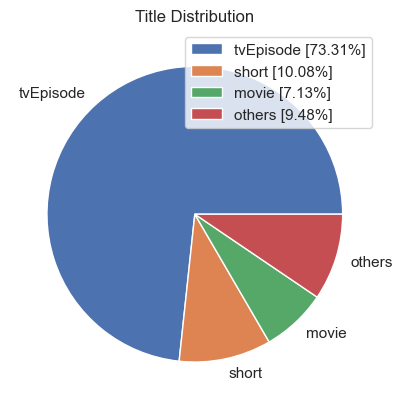

In [72]:
#Creating plot
plt.pie(x=plotData.values(), labels=plotData.keys())
plt.legend(labels= [f'{key} [{value}%]' for key, value in plotData.items()]) #Make legend, get labels with a list chomprehntion
plt.title('Title Distribution')
plt.show()
#Color style


In [104]:
del(plotData)
del(result)
del(others)

# 2- Number of titles by genre

In [91]:
genreTitle = pd.read_sql_query('SELECT genres, COUNT(*) FROM titles WHERE type="movie" GROUP BY genres', con)

In [96]:
genreTitle.sort_values(by='COUNT(*)', ascending=False)

,genres,COUNT(*)
1061,Drama,108302
948,Documentary,82005
1445,\N,70641
705,Comedy,42277
1309,Horror,14108
...,...,...
976,"Documentary,Family,Short",1
1255,"Fantasy,Romance,Sport",1
975,"Documentary,Family,Sci-Fi",1
1257,"Fantasy,Romance,War",1


## Cleaning

In [97]:
#put in lower
genreTitle['genres'] = genreTitle['genres'].str.lower()

In [102]:
#Drop NA
genreTitle['genres'] = genreTitle['genres'].dropna()

In [103]:
genreTitle

,genres,COUNT(*)
0,action,13366
1,"action,adult",11
2,"action,adult,adventure",1
3,"action,adult,comedy",5
4,"action,adult,crime",10
...,...,...
1441,"thriller,western",39
1442,war,1252
1443,"war,western",9
1444,western,4010


## Countvectorizer

Use countervectorizer to discovery the real genres count, this will be used because some genres are together with others and SQL COUNT(*) can't segregate them

In [124]:
patern = r'\b\w[\w-]+\b' #regex with instruction to get the genres betwen commas
temp =  genreTitle['genres']
vector = CountVectorizer(token_pattern=patern, analyzer='word').fit(temp)

In [125]:
type(vector)

sklearn.feature_extraction.text.CountVectorizer

In [126]:
#Creating Bag of words (matrix)
bag_genre = vector.transform(temp)

In [127]:
type(bag_genre)

scipy.sparse.csr.csr_matrix

In [128]:
uniques_genres = vector.get_feature_names()

In [129]:
uniques_genres[:5]

['action', 'adult', 'adventure', 'animation', 'biography']

In [130]:
genres = pd.DataFrame(data=bag_genre.todense(), columns=uniques_genres, index=temp.index)

In [137]:
genres.sum().sort_values(ascending=False)

drama          266
comedy         245
documentary    231
adventure      215
action         211
romance        195
crime          188
mystery        182
thriller       179
fantasy        177
horror         171
history        170
animation      162
music          160
family         160
biography      154
sci-fi         154
musical        151
war            130
western        128
sport          118
adult           89
news            52
reality-tv      42
film-noir       34
short           25
talk-show       14
game-show        7
dtype: int64

In [163]:
genre_percentual = (genres.sum().sort_values(ascending=False)/len(genres.index)) * 100 #get percentage and create a pd.Series

In [164]:
genre_percentual.head(10)

drama          18.395574
comedy         16.943292
documentary    15.975104
adventure      14.868603
action         14.591978
romance        13.485477
crime          13.001383
mystery        12.586445
thriller       12.378976
fantasy        12.240664
dtype: float64

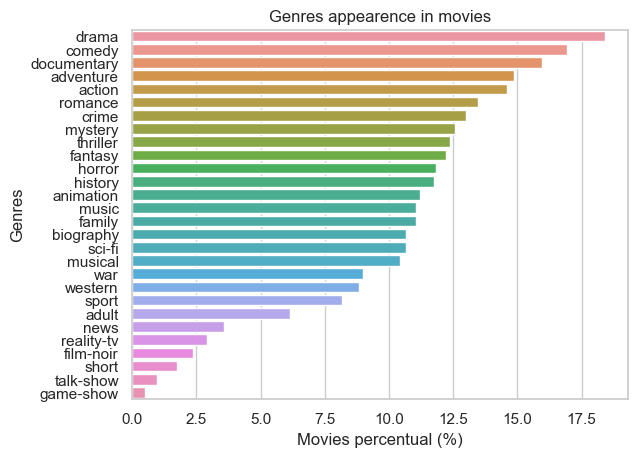

In [173]:
sns.barplot(x=genre_percentual.values, y=genre_percentual.index)
plt.xlabel('Movies percentual (%)')
plt.ylabel('Genres')
plt.title('Genres appearence in movies')
plt.show()